# Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator <br>-- Correctness Testing --

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for variable density visco- acoustics using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *skew self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. There are three notebooks in this series:

##### 1. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Nonlinear Ops
- Implement the nonlinear modeling operations. 
- [ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb)

##### 2. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Linearized Ops
- Implement the linearized (Jacobian) ```forward``` and ```adjoint``` modeling operations.
- [ssa_02_iso_implementation2.ipynb](ssa_02_iso_implementation2.ipynb)

##### 3. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Correctness Testing
- Tests the correctness of the implemented operators.
- [ssa_03_iso_correctness.ipynb](ssa_03_iso_correctness.ipynb)

There are similar series of notebooks implementing and testing operators for VTI and TTI anisotropy ([README.md](README.md)).

Below we describe a suite of unit tests that prove correctness for our *skew self adjoint* operators.

## Outline 
1. Define symbols [[link]](#c_symbols)
2. Definition of correctness tests [[link]](#c_howto)
3. Analytic response in the far field [[link]]("#c_analytic")
4. Modeling operator linearity test, with respect to source [[link]]("#c_F_linearity")
5. Modeling operator adjoint test, with respect to source [[link]]("#c_F_adjoint")
6. Nonlinear operator linearization test, with respect to model [[link]]("#c_F_linearization")
7. Jacobian operator linearity test, with respect to model [[link]]("#c_J_linearity")
8. Jacobian operator adjoint test, with respect to model [[link]]("#c_J_adjoint")
9. Skew symmetry test for shifted derivatives [[link]]("#c_ssa_derivs")
10. References [[link]]("#refs")

<a id="c_symbols"></a>
## Table of symbols

We show the symbols here relevant to the implementation of the linearized operators.

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $\overleftarrow{\partial_t}$ | shifted first derivative wrt $t$ | shifted 1/2 sample backward in time |
| $\partial_{tt}$ | centered second derivative wrt $t$ | centered in time |
| $\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 sample forward in space |
| $\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 sample backward in space |
| $m(x,y,z)$ | Total P wave velocity ($m_0+\delta m$) | function of space |
| $m_0(x,y,z)$ | Reference P wave velocity    | function of space |
| $\delta m(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u(t,x,y,z)$ | Total pressure wavefield ($u_0+\delta u$)| function of time and space |
| $u_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $\delta r(t,x,y,z)$ | Receiver wavefield perturbation | function of time, localized in space to receiver locations |
| $F[m]\ q$ | Forward linear modeling operator | Nonlinear in $m$, linear in $q, s$: $\quad$ maps $q \rightarrow s$ |
| $\bigl( F[m] \bigr)^\top\ s$ | Adjoint linear modeling operator | Nonlinear in $m$, linear in $q, s$: $\quad$ maps $s \rightarrow q$ |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta m$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta m \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta m$ |
| $\Delta_t, \Delta_x, \Delta_y, \Delta_z$ | sampling rates for $t, x, y , z$ | $t, x, y , z$ |  

## A word about notation 

We use the arrow symbols over derivatives $\overrightarrow{\partial_x}$ as a shorthand notation to indicate that the derivative is taken at a shifted location. For example:

- $\overrightarrow{\partial_x}\ u(t,x,y,z)$ indicates that the $x$ derivative of $u(t,x,y,z)$ is taken at $u(t,x+\frac{\Delta x}{2},y,z)$.

- $\overleftarrow{\partial_z}\ u(t,x,y,z)$ indicates that the $z$ derivative of $u(t,x,y,z)$ is taken at $u(t,x,y,z-\frac{\Delta z}{2})$.

- $\overleftarrow{\partial_t}\ u(t,x,y,z)$ indicates that the $t$ derivative of $u(t,x,y,z)$ is taken at $u(t-\frac{\Delta_t}{2},x,y,z)$.

We usually drop the $(t,x,y,z)$ notation from wavefield variables unless required for clarity of exposition, so that $u(t,x,y,z)$ becomes $u$.

<a id="c_howto"></a>
## Definition of correctness tests

We believe that if an operator passes the following suite of unit tests, it can be considered to be *righteous*.

## 1. Analytic response in the far field
Test that data generated in a wholespace matches analogous analytic data away from the near field. We re-use the material shown in the [examples/seismic/acoustic/accuracy.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/acoustic/accuracy.ipynb) notebook. 
<br>

## 2. Modeling operator linearity test, with respect to source
For random vectors $s$ and $r$, prove:

$$
\begin{aligned}
F[m]\ (\alpha\ s) &\approx \alpha\ F[m]\ s \\[5pt]
F[m]^\top (\alpha\ r) &\approx \alpha\ F[m]^\top r \\[5pt]
\end{aligned}
$$
## 3. Modeling operator adjoint test, with respect to source
For random vectors $s$ and $r$, prove:

$$
r \cdot F[m]\ s \approx s \cdot F[m]^\top r
$$

## 4. Nonlinear operator linearization test, with respect to model
For initial velocity model $m$ and random perturbation $\delta m$ prove that the $L_2$ norm error in the linearization $E(h)$ is second order (decreases quadratically) with the magnitude of the perturbation.

$$
E(h) = \biggl\|\ f(m+h\ \delta m) - f(m) - h\ \nabla F[m; q]\ \delta m\ \biggr\|
$$

One way to do this is to run a suite of $h$ values decreasing by a factor of $\gamma$, and prove the error decreases by a factor of $\gamma^2$:  

$$
\frac{E\left(h\right)}{E\left(h/\gamma\right)} \approx \gamma^2
$$

Elsewhere in Devito tutorials, this relation is proven by fitting a line to a sequence of $E(h)$ for various $h$ and showing second order error decrease. We employ this strategy here.

## 5. Jacobian operator linearity test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\begin{aligned}
\nabla F[m; q]\ (\alpha\ \delta m) &\approx \alpha\ \nabla F[m; q]\ \delta m \\[5pt]
(\nabla F[m; q])^\top (\alpha\ \delta r) &\approx \alpha\ (\nabla F[m; q])^\top \delta r
\end{aligned}
$$

## 6. Jacobian operator adjoint test, with respect to model perturbation and receiver wavefield perturbation 
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\delta r \cdot \nabla F[m; q]\ \delta m \approx \delta m \cdot (\nabla F[m; q])^\top \delta r
$$

## 7. Skew symmetry for shifted derivatives
In addition to these tests, recall that in the first notebook ([ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb)) we implemented a unit test that demonstrates skew symmetry of the Devito generated shifted derivatives. We include that test in our suite of unit tests for completeness. 

Ensure for random $f_1, g_1$ that Devito shifted derivative operators $\overrightarrow{\partial_x}$ and $\overrightarrow{\partial_x}$ are skew symmetric by verifying the following dot product test.

$$
f_1 \cdot g_2 \approx -\ g_1 \cdot f_2
$$

## Implementation of correctness tests

Below we implement the correctness tests described above. These tests are copied from standalone tests that run in the Devito project *continuous integration* (CI) pipeline via the script ```test_iso_wavesolver.py```. We will implement the test methods in one cell and then call from the next cell to verify correctness, but note that a wider variety of parameterization is tested in the CI pipeline.

For these tests we use the convenience functions implemented in ```operators.py``` and ```wavesolver.py``` rather than implement the operators in the notebook as we have in the first two notebooks in this series. Please review the source to compare with our notebook implementations:
- [operators.py](operators.py)
- [wavesolver.py](wavesolver.py)
- [test_wavesolver_iso.py](test_wavesolver_iso.py)

**Important note:** you must run these notebook cells in order, because some cells have dependencies on state initialized in previous cells.

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [1]:
from scipy.special import hankel2
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.skew_self_adjoint import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set the default language to openmp
configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

<a id="c_analytic"></a>
## 1. Analytic response in the far field
Test that data generated in a wholespace matches analogous analytic data away from the near field. We copy/modify the material shown in the [examples/seismic/acoustic/accuracy.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/acoustic/accuracy.ipynb) notebook.

#### Analytic solution for the 2D acoustic wave equation

$$
\begin{aligned}
u_s(r, t) &= \frac{1}{2\pi} \int_{-\infty}^{\infty} \bigl\{ -i\ \pi\ H_0^{(2)}\left(k r \right)\ 
q(\omega)\ e^{i\omega t}\ d\omega\bigr\}\\[10pt]
r &= \sqrt{(x_{src} - x_{rec})^2+(z_{src} - z_{rec})^2}
\end{aligned}
$$

where $H_0^{(2)}$ is the Hankel function of the second kind, $F(\omega)$ is the Fourier spectrum of the source time function at angular frequencies $\omega$ and $k = (\omega\ /\ v)$ is the wavenumber. We look at the analytical and numerical solution at a single grid point.

Note that we use a custom discretization for the analytic test that is much finer both temporally and spatially.

In [2]:
# Define the analytic response
def analytic_response(fpeak, time_axis, src_coords, rec_coords, v):
    nt = time_axis.num
    dt = time_axis.step
    v0 = v.data[0,0]
    sx, sz = src_coords[0, :]
    rx, rz = rec_coords[0, :]
    ntpad = 20 * (nt - 1) + 1
    tmaxpad = dt * (ntpad - 1)
    time_axis_pad = TimeAxis(start=tmin, stop=tmaxpad, step=dt)
    timepad = np.linspace(tmin, tmaxpad, ntpad)
    print(time_axis)
    print(time_axis_pad)
    srcpad = RickerSource(name='srcpad', grid=v.grid, f0=fpeak, npoint=1, 
                          time_range=time_axis_pad, t0w=t0w)
    nf = int(ntpad / 2 + 1)
    fnyq = 1.0 / (2 * dt)
    df = 1.0 / tmaxpad
    faxis = df * np.arange(nf)

    # Take the Fourier transform of the source time-function
    R = np.fft.fft(srcpad.wavelet[:])
    R = R[0:nf]
    nf = len(R)

    # Compute the Hankel function and multiply by the source spectrum
    U_a = np.zeros((nf), dtype=complex)
    for a in range(1, nf - 1):
        w = 2 * np.pi * faxis[a] 
        r = np.sqrt((rx - sx)**2 + (rz - sz)**2)
        U_a[a] = -1j * np.pi * hankel2(0.0,  w * r / v0) * R[a]

    # Do inverse fft on 0:dt:T and you have analytical solution
    U_t = 1.0/(2.0 * np.pi) * np.real(np.fft.ifft(U_a[:], ntpad))

    # Note that the analytic solution is scaled by dx^2 to convert to pressure
    return (np.real(U_t) * (dx**2))

In [3]:
# Setup time / frequency
nt = 1001
dt = 0.1
tmin = 0.0
tmax = dt * (nt - 1)
fpeak = 0.090
t0w = 1.0 / fpeak
omega = 2.0 * np.pi * fpeak
time_axis = TimeAxis(start=tmin, stop=tmax, step=dt)
time = np.linspace(tmin, tmax, nt)

# Model
space_order = 8
npad = 50
dx, dz = 0.5, 0.5
nx, nz = 801 + 2 * npad, 801 + 2 * npad
shape = (nx, nz)
spacing = (dx, dz)
extent = (dx * (nx - 1), dz * (nz - 1))
origin = (0.0 - dx * npad, 0.0 - dz * npad)
dtype = np.float64
qmin = 0.1
qmax = 100000
v0 = 1.5
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=dx))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=dz))
grid = Grid(extent=extent, shape=shape, origin=origin,
            dimensions=(x, z), dtype=dtype)
b = Function(name='b', grid=grid, space_order=space_order)
v = Function(name='v', grid=grid, space_order=space_order)
b.data[:] = 1.0
v.data[:] = v0

# Source and reciver coordinates 
src_coords = np.empty((1, 2), dtype=dtype)
rec_coords = np.empty((1, 2), dtype=dtype)
src_coords[:, 0] = origin[0] + extent[0] / 2
src_coords[:, 1] = origin[1] + extent[1] / 2
rec_coords[:, 0] = origin[0] + extent[0] / 2 + 60
rec_coords[:, 1] = origin[1] + extent[1] / 2 + 60

# Solver setup
solver = SSA_ISO_AcousticWaveSolver(npad, qmin, qmax, omega, b, v,
                                    src_coords, rec_coords, time_axis,
                                    space_order=space_order)

# Source function 
src = RickerSource(name='src', grid=v.grid, f0=fpeak, npoint=1, 
                   time_range=time_axis, t0w=t0w)
src.coordinates.data[:] = src_coords[:]

# Numerical solution
recNum, uNum, _ = solver.forward(src)

# Analytic solution
uAnaPad = analytic_response(fpeak, time_axis, src_coords, rec_coords, v)
uAna = uAnaPad[0:nt]

# Compute RMS and difference
diff = (recNum.data - uAna)
nrms = np.max(np.abs(recNum.data))
arms = np.max(np.abs(uAna))
drms = np.max(np.abs(diff))

print("\nMaximum absolute numerical,analytic,diff; %+12.6e %+12.6e %+12.6e" % (nrms, arms, drms))

# This isnt a very strict tolerance ...
tol = 0.1
assert np.allclose(diff, 0.0, atol=tol)

nmin, nmax = np.min(recNum.data), np.max(recNum.data)
amin, amax = np.min(uAna), np.max(uAna)

print("")
print("Numerical min/max; %+12.6e %+12.6e" % (nmin, nmax))
print("Analytic  min/max; %+12.6e %+12.6e" % (amin, amax))

Operator `WOverQ_Operator` run in 0.01 s
Operator `ISO_FwdOperator` run in 29.43 s


TimeAxis: start=0, stop=100, step=0.1, num=1001
TimeAxis: start=0, stop=2000, step=0.1, num=20001

Maximum absolute numerical,analytic,diff; +8.532029e-03 +8.547096e-03 +1.389771e-02

Numerical min/max; -5.350614e-03 +8.532029e-03
Analytic  min/max; -5.323205e-03 +8.547096e-03


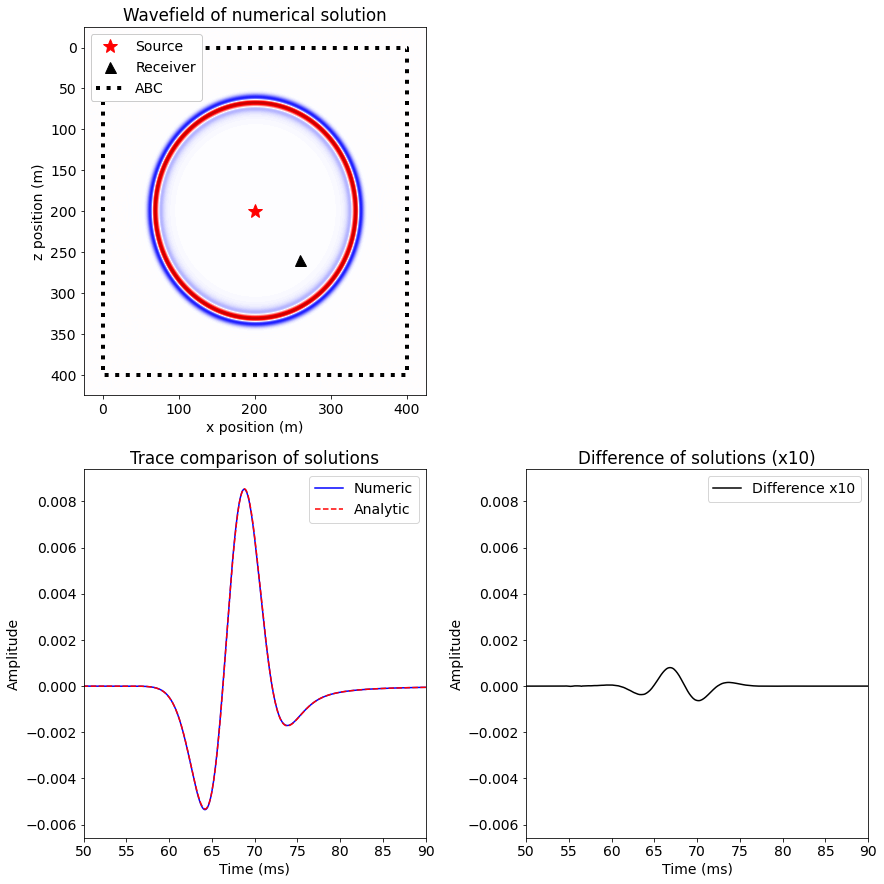

In [4]:
# Plot
x1 = origin[0]
x2 = origin[0] + extent[0]
z1 = origin[1]
z2 = origin[1] + extent[1]

xABC1 = origin[0] + dx * npad
xABC2 = origin[0] + extent[0] - dx * npad
zABC1 = origin[1] + dz * npad
zABC2 = origin[1] + extent[1] - dz * npad

plt_extent = [x1, x2, z2, z1]
abc_pairsX = [xABC1, xABC1, xABC2, xABC2, xABC1] 
abc_pairsZ = [zABC1, zABC2, zABC2, zABC1, zABC1] 

plt.figure(figsize=(12.5,12.5))

# Plot wavefield
plt.subplot(2,2,1)
amax = 1.1 * np.max(np.abs(recNum.data[:]))
plt.imshow(uNum.data[1,:,:], vmin=-amax, vmax=+amax, cmap="seismic",
           aspect="auto", extent=plt_extent)
plt.plot(src_coords[0, 0], src_coords[0, 1], 'r*', markersize=15, label='Source') 
plt.plot(rec_coords[0, 0], rec_coords[0, 1], 'k^', markersize=11, label='Receiver') 
plt.plot(abc_pairsX, abc_pairsZ, 'black', linewidth=4, linestyle=':', 
         label="ABC")
plt.legend(loc="upper left", bbox_to_anchor=(0.0, 0.9, 0.35, .1), framealpha=1.0)
plt.xlabel('x position (m)')
plt.ylabel('z position (m)')
plt.title('Wavefield of numerical solution')
plt.tight_layout()

# Plot trace
plt.subplot(2,2,3)
plt.plot(time, recNum.data[:, 0], '-b', label='Numeric')
plt.plot(time, uAna[:], '--r', label='Analytic')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Trace comparison of solutions')
plt.legend(loc="upper right")
plt.xlim([50,90])
plt.ylim([-0.7 * amax, +amax])

plt.subplot(2,2,4)
plt.plot(time, 10 * (recNum.data[:, 0] -  uAna[:]), '-k', label='Difference x10')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Difference of solutions (x10)')
plt.legend(loc="upper right")
plt.xlim([50,90])
plt.ylim([-0.7 * amax, +amax])

plt.tight_layout()
plt.show()

## Reset default shapes for subsequent tests

In [5]:
npad = 10
fpeak = 0.010
qmin = 0.1
qmax = 500.0
tmax = 1000.0
shape = (101, 81)

<a id="c_F_linearity"></a>
## 2. Modeling operator linearity test, with respect to source
For random vectors $s$ and $r$, prove:

$$
\begin{aligned}
F[m]\ (\alpha\ s) &\approx \alpha\ F[m]\ s \\[5pt]
F[m]^\top (\alpha\ r) &\approx \alpha\ F[m]^\top r \\[5pt]
\end{aligned}
$$

We first test the forward operator, and in the cell below that the adjoint operator.

In [6]:
omega = 2.0 * np.pi * fpeak
b, v, time_axis, src_coords, rec_coords = \
    defaultSetupIso(npad, shape, dtype, tmax=tmax)
solver = SSA_ISO_AcousticWaveSolver(npad, qmin, qmax, omega, b, v,
                                    src_coords, rec_coords, time_axis,
                                    space_order=8)
src = RickerSource(name='src', grid=v.grid, f0=fpeak, npoint=1,
                   time_range=time_axis)
src.coordinates.data[:] = src_coords[:]
a = -1 + 2 * np.random.rand()
rec1, _, _ = solver.forward(src)
src.data[:] *= a
rec2, _, _ = solver.forward(src)
rec1.data[:] *= a

# Check receiver wavefeild linearity
# Normalize by rms of rec2, to enable using abolute tolerance below
rms2 = np.sqrt(np.mean(rec2.data**2))
diff = (rec1.data - rec2.data) / rms2
print("\nlinearity forward F %s (so=%d) rms 1,2,diff; "
      "%+16.10e %+16.10e %+16.10e" %
      (shape, 8, np.sqrt(np.mean(rec1.data**2)), np.sqrt(np.mean(rec2.data**2)),
       np.sqrt(np.mean(diff**2))))
tol = 1.e-12
assert np.allclose(diff, 0.0, atol=tol)

Operator `WOverQ_Operator` run in 0.01 s
Operator `ISO_FwdOperator` run in 12.15 s
Operator `ISO_FwdOperator` run in 14.25 s



linearity forward F (101, 81) (so=8) rms 1,2,diff; +9.5190444054e+02 +9.5190444054e+02 +3.8139845837e-15


In [7]:
src0 = RickerSource(name='src0', grid=v.grid, f0=fpeak, npoint=1,
                    time_range=time_axis)
src0.coordinates.data[:] = src_coords[:]
rec, _, _ = solver.forward(src0)
a = -1 + 2 * np.random.rand()
src1, _, _ = solver.adjoint(rec)
rec.data[:] = a * rec.data[:]
src2, _, _ = solver.adjoint(rec)
src1.data[:] *= a

# Check adjoint source wavefeild linearity
# Normalize by rms of rec2, to enable using abolute tolerance below
rms2 = np.sqrt(np.mean(src2.data**2))
diff = (src1.data - src2.data) / rms2
print("\nlinearity adjoint F %s (so=%d) rms 1,2,diff; "
      "%+16.10e %+16.10e %+16.10e" %
      (shape, 8, np.sqrt(np.mean(src1.data**2)), np.sqrt(np.mean(src2.data**2)),
       np.sqrt(np.mean(diff**2))))
tol = 1.e-12
assert np.allclose(diff, 0.0, atol=tol)

Operator `ISO_FwdOperator` run in 10.98 s
Operator `ISO_AdjOperator` run in 6.41 s
Operator `ISO_AdjOperator` run in 3.55 s



linearity adjoint F (101, 81) (so=8) rms 1,2,diff; +2.3483342780e+08 +2.3483342780e+08 +2.3026098386e-15


<a id="c_F_adjoint"></a>
## 3. Modeling operator adjoint test, with respect to source
For random vectors $s$ and $r$, prove:

$$
r \cdot F[m]\ s \approx s \cdot F[m]^\top r
$$

In [8]:
src1 = RickerSource(name='src1', grid=v.grid, f0=fpeak, npoint=1,
                    time_range=time_axis)
src1.coordinates.data[:] = src_coords[:]

rec1 = Receiver(name='rec1', grid=v.grid, time_range=time_axis,
                coordinates=rec_coords)
rec2, _, _ = solver.forward(src1)
# flip sign of receiver data for adjoint to make it interesting
rec1.data[:] = rec2.data[:]
src2, _, _ = solver.adjoint(rec1)
sum_s = np.dot(src1.data.reshape(-1), src2.data.reshape(-1))
sum_r = np.dot(rec1.data.reshape(-1), rec2.data.reshape(-1))
diff = (sum_s - sum_r) / (sum_s + sum_r)
print("\nadjoint F %s (so=%d) sum_s, sum_r, diff; %+16.10e %+16.10e %+16.10e" %
      (shape, 8, sum_s, sum_r, diff))
assert np.isclose(diff, 0., atol=1.e-12)

Operator `ISO_FwdOperator` run in 7.61 s
Operator `ISO_AdjOperator` run in 0.97 s



adjoint F (101, 81) (so=8) sum_s, sum_r, diff; +1.7074302611e+11 +1.7074302611e+11 -2.6810094813e-16


<a id="c_F_linearization"></a>
## 4. Nonlinear operator linearization test, with respect to model

For initial velocity model $m$ and random perturbation $\delta m$ prove that the $L_2$ norm error in the linearization $E(h)$ is second order (decreases quadratically) with the magnitude of the perturbation.

$$
E(h) = \biggl\|\ f(m+h\ \delta m) - f(m) - h\ \nabla F[m; q]\ \delta m\ \biggr\|
$$

One way to do this is to run a suite of $h$ values decreasing by a factor of $\gamma$, and prove the error decreases by a factor of $\gamma^2$:  

$$
\frac{E\left(h\right)}{E\left(h/\gamma\right)} \approx \gamma^2
$$

Elsewhere in Devito tutorials, this relation is proven by fitting a line to a sequence of $E(h)$ for various $h$ and showing second order error decrease. We employ this strategy here.

In [9]:
omega = 2.0 * np.pi * fpeak
b, v, time_axis, src_coords, rec_coords = \
    defaultSetupIso(npad, shape, dtype, tmax=tmax)
solver = SSA_ISO_AcousticWaveSolver(npad, qmin, qmax, omega, b, v,
                                    src_coords, rec_coords, time_axis,
                                    space_order=8)

src = RickerSource(name='src', grid=v.grid, f0=fpeak, npoint=1,
                   time_range=time_axis)
src.coordinates.data[:] = src_coords[:]

# Create Functions for models and perturbation
m0 = Function(name='m0', grid=v.grid, space_order=8)
mm = Function(name='mm', grid=v.grid, space_order=8)
dm = Function(name='dm', grid=v.grid, space_order=8)

# Background model
m0.data[:] = 1.5

# Model perturbation, box of random values centered on middle of model
dm.data[:] = 0
size = 5
ns = 2 * size + 1
nx2, nz2 = shape[0]//2, shape[1]//2
dm.data[nx2-size:nx2+size, nz2-size:nz2+size] = -1 + 2 * np.random.rand(ns, ns)

# Compute F(m + dm)
rec0, u0, summary0 = solver.forward(src, v=m0)

# Compute J(dm)
rec1, u1, du, summary1 = solver.jacobian_forward(dm, src=src, v=m0)

# Linearization test via polyfit (see devito/tests/test_gradient.py)
# Solve F(m + h dm) for sequence of decreasing h
dh = np.sqrt(2.0)
h = 0.1
nstep = 7
scale = np.empty(nstep)
norm1 = np.empty(nstep)
norm2 = np.empty(nstep)
for kstep in range(nstep):
    h = h / dh
    mm.data[:] = m0.data + h * dm.data
    rec2, _, _ = solver.forward(src, v=mm)
    scale[kstep] = h
    norm1[kstep] = 0.5 * np.linalg.norm(rec2.data - rec0.data)**2
    norm2[kstep] = 0.5 * np.linalg.norm(rec2.data - rec0.data - h * rec1.data)**2

# Fit 1st order polynomials to the error sequences
#   Assert the 1st order error has slope dh^2
#   Assert the 2nd order error has slope dh^4
p1 = np.polyfit(np.log10(scale), np.log10(norm1), 1)
p2 = np.polyfit(np.log10(scale), np.log10(norm2), 1)
print("\nlinearization F %s (so=%d) 1st (%.1f) = %.4f, 2nd (%.1f) = %.4f" %
      (shape, 8, dh**2, p1[0], dh**4, p2[0]))
assert np.isclose(p1[0], dh**2, rtol=0.1)
assert np.isclose(p2[0], dh**4, rtol=0.1)

Operator `WOverQ_Operator` run in 0.01 s
Operator `ISO_FwdOperator` run in 3.32 s
Operator `ISO_JacobianFwdOperator` run in 0.10 s
Operator `ISO_FwdOperator` run in 0.05 s
Operator `ISO_FwdOperator` run in 0.05 s
Operator `ISO_FwdOperator` run in 0.05 s
Operator `ISO_FwdOperator` run in 0.05 s
Operator `ISO_FwdOperator` run in 0.08 s
Operator `ISO_FwdOperator` run in 0.05 s
Operator `ISO_FwdOperator` run in 0.05 s



linearization F (101, 81) (so=8) 1st (2.0) = 1.9692, 2nd (4.0) = 3.9728


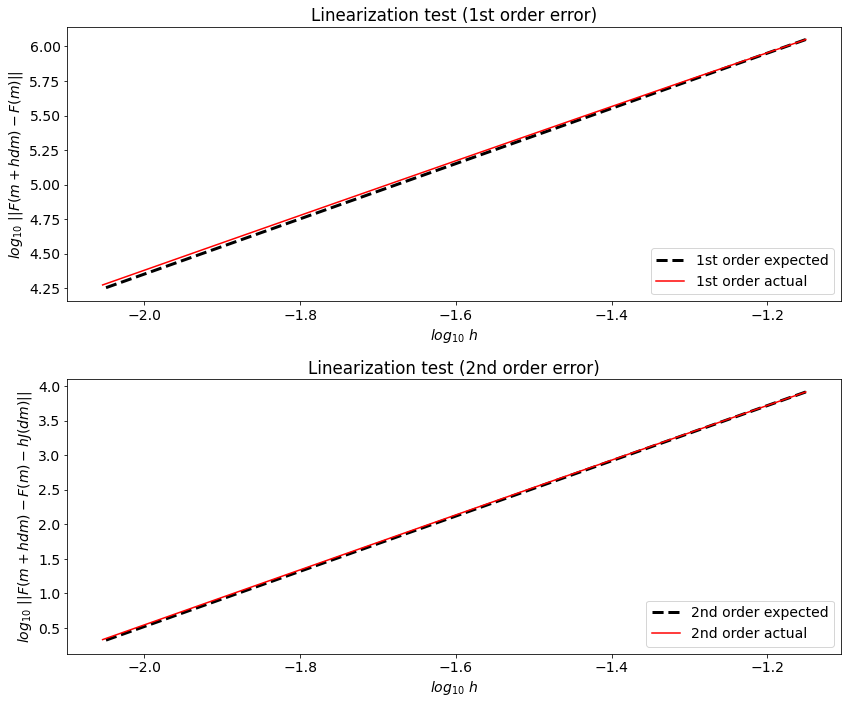

In [10]:
# Plot linearization tests
plt.figure(figsize=(12,10))

expected1 = np.empty(nstep)
expected2 = np.empty(nstep)

expected1[0] = norm1[0]
expected2[0] = norm2[0]

for kstep in range(1, nstep):
    expected1[kstep] = expected1[kstep - 1] / (dh**2)
    expected2[kstep] = expected2[kstep - 1] / (dh**4)

plt.subplot(2,1,1)
plt.plot(np.log10(scale), np.log10(expected1), '--k', label='1st order expected', linewidth=3)
plt.plot(np.log10(scale), np.log10(norm1), '-r', label='1st order actual', linewidth=1.5)
plt.xlabel('$log_{10}\ h$')
plt.ylabel('$log_{10}\ \|| F(m+h dm) - F(m) \||$')
plt.title('Linearization test (1st order error)')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(np.log10(scale), np.log10(expected2), '--k', label='2nd order expected', linewidth=3)
plt.plot(np.log10(scale), np.log10(norm2), '-r', label='2nd order actual', linewidth=1.5)
plt.xlabel('$log_{10}\ h$')
plt.ylabel('$log_{10}\ \|| F(m+h dm) - F(m) - h J(dm)\||$')
plt.title('Linearization test (2nd order error)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

<a id="c_J_linearity"></a>
## 5. Jacobian operator linearity test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\begin{aligned}
\nabla F[m; q]\ (\alpha\ \delta m) &\approx \alpha\ \nabla F[m; q]\ \delta m \\[5pt]
(\nabla F[m; q])^\top (\alpha\ \delta r) &\approx \alpha\ (\nabla F[m; q])^\top \delta r
\end{aligned}
$$

We first test the forward operator, and in the cell below that the adjoint operator.

In [11]:
src0 = RickerSource(name='src0', grid=v.grid, f0=fpeak, npoint=1,
                    time_range=time_axis)
src0.coordinates.data[:] = src_coords[:]

m0 = Function(name='m0', grid=v.grid, space_order=8)
m1 = Function(name='m1', grid=v.grid, space_order=8)
m0.data[:] = 1.5

# Model perturbation, box of random values centered on middle of model
m1.data[:] = 0
size = 5
ns = 2 * size + 1
nx2, nz2 = shape[0]//2, shape[1]//2
m1.data[nx2-size:nx2+size, nz2-size:nz2+size] = \
    -1 + 2 * np.random.rand(ns, ns)

a = np.random.rand()
rec1, _, _, _ = solver.jacobian_forward(m1, src0, v=m0, save=nt)
rec1.data[:] = a * rec1.data[:]
m1.data[:] = a * m1.data[:]
rec2, _, _, _ = solver.jacobian_forward(m1, src0, v=m0, save=nt)

# Normalize by rms of rec2, to enable using abolute tolerance below
rms2 = np.sqrt(np.mean(rec2.data**2))
diff = (rec1.data - rec2.data) / rms2
print("\nlinearity forward J %s (so=%d) rms 1,2,diff; "
      "%+16.10e %+16.10e %+16.10e" %
      (shape, 8, np.sqrt(np.mean(rec1.data**2)), np.sqrt(np.mean(rec2.data**2)),
       np.sqrt(np.mean(diff**2))))
tol = 1.e-12
assert np.allclose(diff, 0.0, atol=tol)


Operator `ISO_JacobianFwdOperator` run in 0.09 s
Operator `ISO_JacobianFwdOperator` run in 0.07 s



linearity forward J (101, 81) (so=8) rms 1,2,diff; +2.5480460374e+01 +2.5480460374e+01 +6.0993360367e-15


In [12]:
src0 = RickerSource(name='src0', grid=v.grid, f0=fpeak, npoint=1,
                    time_range=time_axis)
src0.coordinates.data[:] = src_coords[:]

m0 = Function(name='m0', grid=v.grid, space_order=8)
m1 = Function(name='m1', grid=v.grid, space_order=8)
m0.data[:] = 1.5

# Model perturbation, box of random values centered on middle of model
m1.data[:] = 0
size = 5
ns = 2 * size + 1
nx2, nz2 = shape[0]//2, shape[1]//2
m1.data[nx2-size:nx2+size, nz2-size:nz2+size] = \
    -1 + 2 * np.random.rand(ns, ns)

a = np.random.rand()
rec0, u0, _ = solver.forward(src0, v=m0, save=nt)
dm1, _, _, _ = solver.jacobian_adjoint(rec0, u0, v=m0, save=nt)
dm1.data[:] = a * dm1.data[:]
rec0.data[:] = a * rec0.data[:]
dm2, _, _, _ = solver.jacobian_adjoint(rec0, u0, v=m0, save=nt)

# Normalize by rms of rec2, to enable using abolute tolerance below
rms2 = np.sqrt(np.mean(dm2.data**2))
diff = (dm1.data - dm2.data) / rms2
print("\nlinearity adjoint J %s (so=%d) rms 1,2,diff; "
      "%+16.10e %+16.10e %+16.10e" %
      (shape, 8, np.sqrt(np.mean(dm1.data**2)), np.sqrt(np.mean(dm2.data**2)),
       np.sqrt(np.mean(diff**2))))

Operator `ISO_FwdOperator` run in 0.09 s
Operator `ISO_JacobianAdjOperator` run in 0.35 s
Operator `ISO_JacobianAdjOperator` run in 0.07 s



linearity adjoint J (101, 81) (so=8) rms 1,2,diff; +1.9117238439e+08 +1.9117238439e+08 +1.0052185929e-15


<a id="c_J_adjoint"></a>
## 6. Jacobian operator adjoint test, with respect to model perturbation and receiver wavefield perturbation 
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\delta r \cdot \nabla F[m; q]\ \delta m \approx \delta m \cdot (\nabla F[m; q])^\top \delta r
$$

<br>


In [13]:
src0 = RickerSource(name='src0', grid=v.grid, f0=fpeak, npoint=1,
                    time_range=time_axis)
src0.coordinates.data[:] = src_coords[:]

m0 = Function(name='m0', grid=v.grid, space_order=8)
dm1 = Function(name='dm1', grid=v.grid, space_order=8)
m0.data[:] = 1.5

# Model perturbation, box of random values centered on middle of model
dm1.data[:] = 0
size = 5
ns = 2 * size + 1
nx2, nz2 = shape[0]//2, shape[1]//2
dm1.data[nx2-size:nx2+size, nz2-size:nz2+size] = \
    -1 + 2 * np.random.rand(ns, ns)

# Data perturbation
rec1 = Receiver(name='rec1', grid=v.grid, time_range=time_axis,
                coordinates=rec_coords)
nt, nr = rec1.data.shape
rec1.data[:] = np.random.rand(nt, nr)

# Nonlinear modeling
rec0, u0, _ = solver.forward(src0, v=m0, save=nt)

# Linearized modeling
rec2, _, _, _ = solver.jacobian_forward(dm1, src0, v=m0, save=nt)
dm2, _, _, _ = solver.jacobian_adjoint(rec1, u0, v=m0, save=nt)

sum_m = np.dot(dm1.data.reshape(-1), dm2.data.reshape(-1))
sum_d = np.dot(rec1.data.reshape(-1), rec2.data.reshape(-1))
diff = (sum_m - sum_d) / (sum_m + sum_d)
print("\nadjoint J %s (so=%d) sum_m, sum_d, diff; %16.10e %+16.10e %+16.10e" %
      (shape, 8, sum_m, sum_d, diff))
assert np.isclose(diff, 0., atol=1.e-11)

Operator `ISO_FwdOperator` run in 0.05 s
Operator `ISO_JacobianFwdOperator` run in 0.08 s
Operator `ISO_JacobianAdjOperator` run in 0.06 s



adjoint J (101, 81) (so=8) sum_m, sum_d, diff; -1.1859042143e+04 -1.1859042143e+04 -1.9257383258e-13


<a id="c_ssa_derivs"></a>
## 7. Skew symmetry for shifted derivatives

Ensure for random $f_1, g_1$ that Devito shifted derivative operators $\overrightarrow{\partial_x}$ and $\overrightarrow{\partial_x}$ are skew symmetric by verifying the following dot product test.

$$
f_1 \cdot g_2 \approx -\ g_1 \cdot f_2
$$

We verify passing this adjoint test by ensuring that the following relative error terms vanishes.

$$
\frac{\displaystyle f_1 \cdot g_2 + g_1 \cdot f_2}
     {\displaystyle f_1 \cdot g_2 - g_1 \cdot f_2}\ <\ \epsilon
$$

In [14]:
#NBVAL_INGNORE_OUTPUT

# Make 1D grid to test derivatives 
n = 101
d = 1.0
shape = (n, )
spacing = (1 / (n-1), )   
origin = (0., )
extent = (d * (n-1), )
dtype = np.float64

# Initialize Devito grid and Functions for input(f1,g1) and output(f2,g2)
# Note that space_order=8 allows us to use an 8th order finite difference 
#   operator by properly setting up grid accesses with halo cells 
grid1d = Grid(shape=shape, extent=extent, origin=origin, dtype=dtype)
x = grid1d.dimensions[0]
f1 = Function(name='f1', grid=grid1d, space_order=8)
f2 = Function(name='f2', grid=grid1d, space_order=8)
g1 = Function(name='g1', grid=grid1d, space_order=8)
g2 = Function(name='g2', grid=grid1d, space_order=8)

# Fill f1 and g1 with random values in [-1,+1]
f1.data[:] = -1 + 2 * np.random.rand(n,)
g1.data[:] = -1 + 2 * np.random.rand(n,)

# Equation defining: [f2 = forward 1/2 cell shift derivative applied to f1]
equation_f2 = Eq(f2, f1.dx(x0=x+0.5*x.spacing))

# Equation defining: [g2 = backward 1/2 cell shift derivative applied to g1]
equation_g2 = Eq(g2, g1.dx(x0=x-0.5*x.spacing))

# Define an Operator to implement these equations and execute
op = Operator([equation_f2, equation_g2])
op()

# Compute the dot products and the relative error
f1g2 = np.dot(f1.data, g2.data)
g1f2 = np.dot(g1.data, f2.data)
diff = (f1g2+g1f2)/(f1g2-g1f2)

tol = 100 * np.finfo(dtype).eps
print("f1g2, g1f2, diff, tol; %+.6e %+.6e %+.6e %+.6e" % (f1g2, g1f2, diff, tol))

# At last the unit test
# Assert these dot products are float epsilon close in relative error
assert diff < 100 * np.finfo(np.float32).eps

Operator `Kernel` run in 0.01 s


f1g2, g1f2, diff, tol; +2.544719e+00 -2.544719e+00 -1.745140e-16 +2.220446e-14


## Discussion

This concludes the correctness testing of the skew symmetric isotropic visco- acoustic operator. Note that you can run the unit tests directly with the following command, where ```-s``` outputs information about the tolerance and tested values in the tests.

```pytest -s test_wavesolver_iso.py```  

If you would like to continue this tutorial series with the VTI and TTI operators, please see the README for links. 

- [README.md](README.md)

<a id="refs"></a>
## References

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1
